In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)

warnings.filterwarnings('ignore')

Using device:  mps


# Closed Loop implemented as Neural ODE

This is the version included in the initial submission of the paper. In that version, we had trained neural networks before learning closed loop dynamics, so we had to take a forecasting VAE and use only the encoder/decoder portions. We also plotted cuts from $x \in [80, 120]$ pixels (in morphogenesis.forecasting.plot_utils.get_cut)

{'beta': 0.0001,
 'epochs': 500,
 'hidden_size': 128,
 'in_channels': 4,
 'input': ['sqh'],
 'lr': 0.0001,
 'lstm_layers': 2,
 'mode': 'embryo',
 'num_latent': 64,
 'out_channels': 2,
 'output': 'vel',
 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 64]]}
Calibrating flow model to movie intensity
Using custom RHS
Using covariant gradient
Initializing
Using torchdiffeq solver


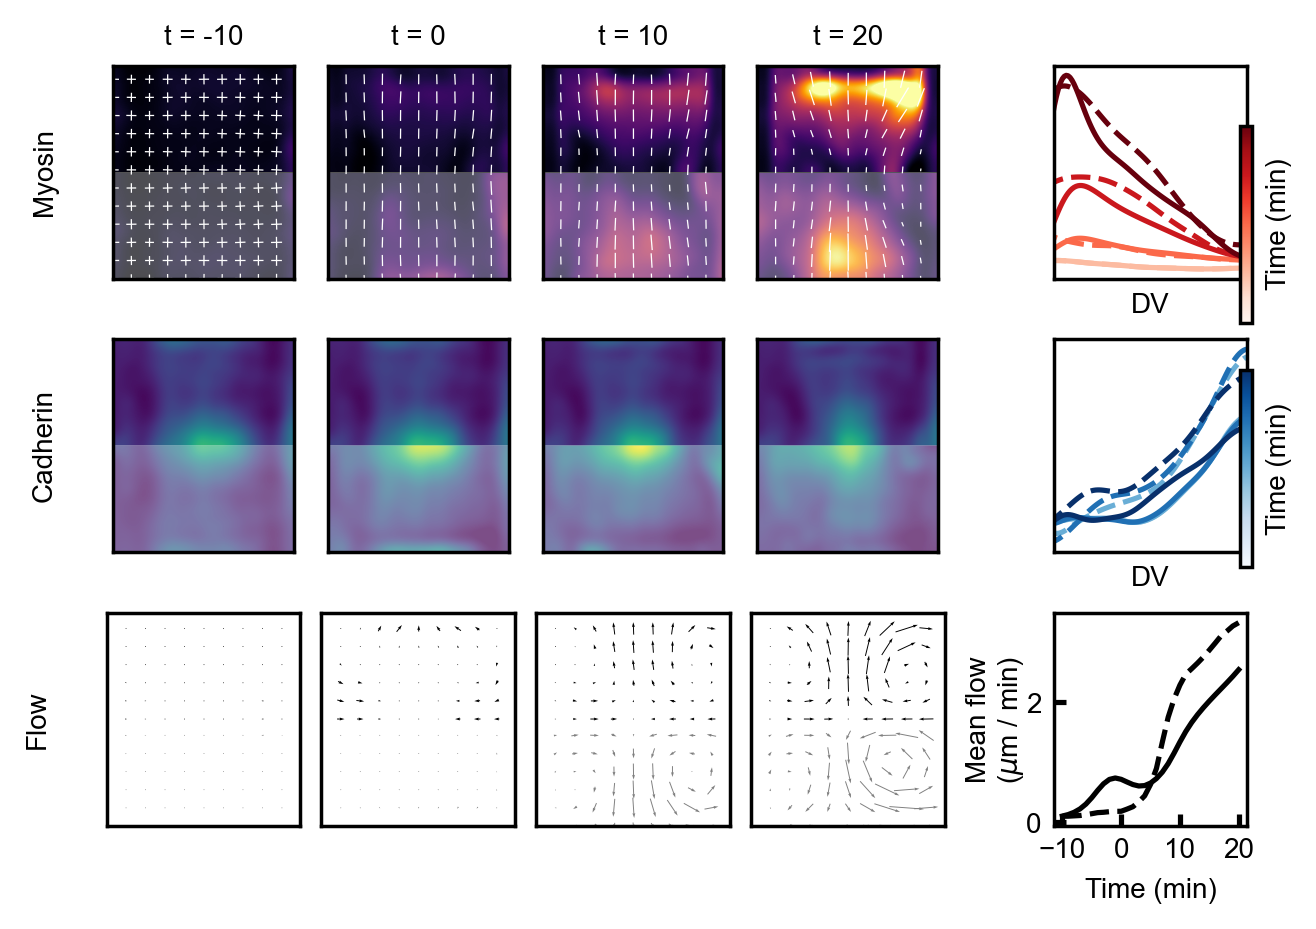

In [2]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.forecasting.plot_utils import *
from morphogenesis.flow_networks.translation_models import VAE
from morphogenesis.flow_networks.forecasting_models import MaskedVAE_Evolver
from pprint import pprint

info = torch.load('../04.TranslationNetworks/tb_logs/ForecastingVAE_sqh_beta=0.0001_split=embryo', map_location='cpu') #Works well with sigma = 5
pprint(info['hparams'])

vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.float().to(device).eval();

#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.FloatTensor(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
y0 = torch.FloatTensor(y0)

def rhs_WT(model, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
    '''
    trm = model.einsum_('kkyx->yx', m)
    trE = model.einsum_('kkyx->yx', E)

    rhs  = -(0.066 - 0.061 * s) * m #Detachment
    rhs +=	(0.489 + 0.318 * s) * m * trE #Strain recruitment
    rhs +=	(0.564 - 0.393 * s) * trm * m #Tension recruitment
    rhs +=	(0.047 - 0.037 * s) * trm * model.gamma_dv_ #Hoop stress recruitment

    return rhs

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_WT, dv_mode='replicate')
model.fit(y0[None])
model.float()

m, s, v = model.integrate(y0.to(device), t0)
comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)

In [6]:
np.save('Figures/Forecasting/m0', m0)
np.save('Figures/Forecasting/v0', v0)
np.save('Figures/Forecasting/c0', s0)
np.save('Figures/Forecasting/m', m)
np.save('Figures/Forecasting/v', v)
np.save('Figures/Forecasting/c', s)
np.save('Figures/Forecasting/time', t0)


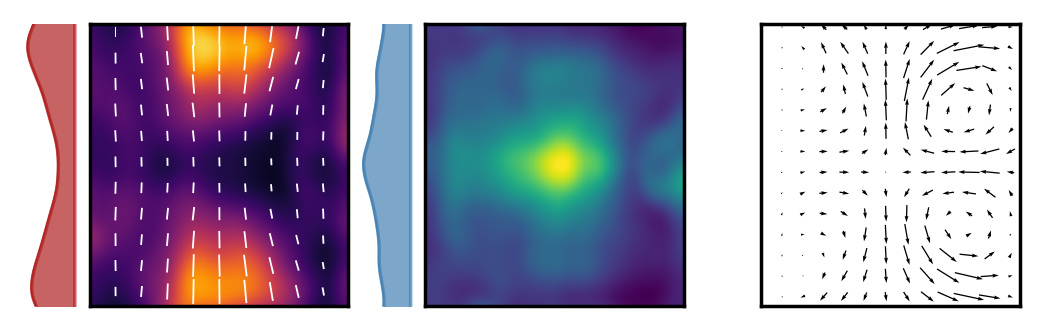

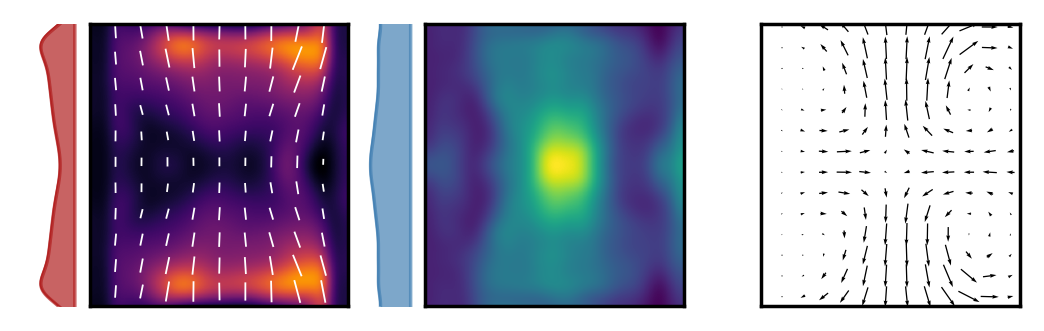

In [7]:
from utils.plot_utils import *
from utils.decomposition.decomposition_model import LeftRightSymmetrize

def plot_cut(ax, z, color):
    znorm = np.linalg.norm(z.reshape([-1, 236, 200]), axis=0)
    cut = np.mean(znorm[:, 80:120], axis=-1)
    
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    y = np.linspace(dv_min, dv_max, cut.shape[0])
    ax_Y.plot(cut, y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 0, cut, color=color, alpha=0.7)
    ax_Y.invert_xaxis()
    ax_Y.axis('off')
    ax.set_ylim([dv_min+of, dv_max-of])    
    return ax_Y


mmin = np.min(np.linalg.norm(m0[..., :-20], axis=(1, 2)))
mmax = np.max(np.linalg.norm(m0[..., :-20], axis=(1, 2)))

of = 20
tt = 25

fig, ax = plt.subplots(1, 3, dpi=250, figsize=(6*0.8, 2))
plot_tensor2D(ax[0], m0[tt], vmin=mmin, vmax=mmax)
ax_m0 = plot_cut(ax[0], m0[tt], 'firebrick')
color_2D(ax[1], s0[tt])
ax_c0 = plot_cut(ax[1], s0[tt], 'steelblue')
plot_vector2D(ax[2], v0[tt], skip=16)
ax[2].set_ylim([dv_min+of, dv_max-of])    
fig.subplots_adjust(wspace=0.3)

fig, ax = plt.subplots(1, 3, dpi=250, figsize=(6*0.8, 2))
mtt = LeftRightSymmetrize().fit_transform(m[tt].reshape([1, 4, 236, 200]))[0]
plot_tensor2D(ax[0], mtt, vmin=mmin, vmax=mmax)
ax_m = plot_cut(ax[0], mtt, 'firebrick')
ax_m.set_xlim(ax_m0.get_xlim())
stt = LeftRightSymmetrize().fit_transform(s[tt:tt+1])[0]
color_2D(ax[1], stt)
ax_c = plot_cut(ax[1], stt, 'steelblue')
ax_c.set_xlim(ax_c0.get_xlim())
plot_vector2D(ax[2], LeftRightSymmetrize().fit_transform(v[tt:tt+1])[0], skip=16)
ax[2].set_ylim([dv_min+of, dv_max-of])    
fig.subplots_adjust(wspace=0.3)
